# **Image Classification of Transport System Dataset**

Mount the GDrive in this Google colab

In [1]:
# Code for mounting your Gdrive

from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import all the important libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir = "/content/drive/MyDrive/caltech101_classification"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1661


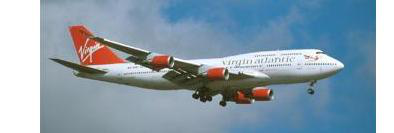

In [5]:
airplanes = list(data_dir.glob('airplanes/*'))
PIL.Image.open(str(airplanes[0]))

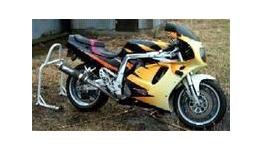

In [6]:
motorbikes = list(data_dir.glob('Motorbikes/*'))
PIL.Image.open(str(motorbikes[5]))

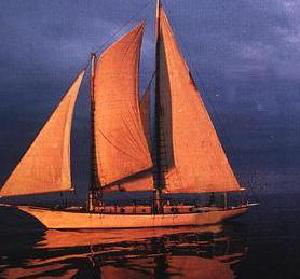

In [7]:
schooner = list(data_dir.glob('schooner/*'))
PIL.Image.open(str(schooner[5]))

Load data using a Keras utility

In [11]:
batch_size = 32
img_height = 48
img_width = 48

Doing validation split on dataset to segregate as train data (80%) and test data (20%)

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1661 files belonging to 3 classes.
Using 1329 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1661 files belonging to 3 classes.
Using 332 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['Motorbikes', 'airplanes', 'schooner']


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 60, 60, 3)
(32,)


Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.15360755 1.0


A basic Keras model

In [22]:
num_classes = len(class_names)

cnn_model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
cnn_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

# CNN Model 1: A Basic Keras Model

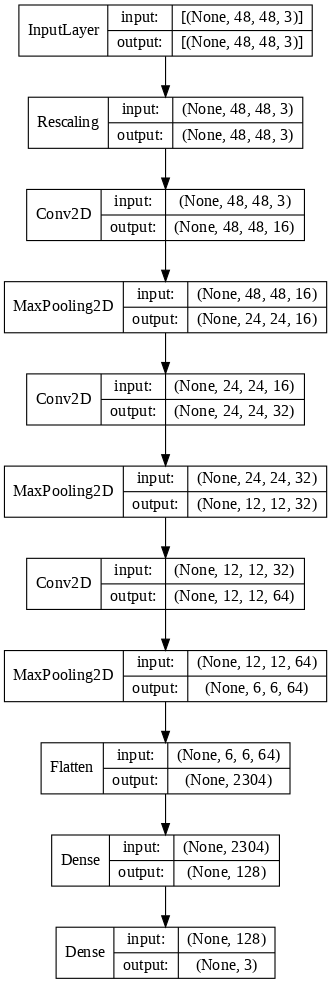

In [168]:
plot_model(cnn_model_1,
           to_file='model1.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [48]:
epochs=10
history_cnn_model_1 = cnn_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
42/42 [==============================] - 7s 145ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9940
Epoch 2/10
42/42 [==============================] - 7s 146ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9940
Epoch 3/10
42/42 [==============================] - 6s 145ms/step - loss: 7.0602e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9970
Epoch 4/10
42/42 [==============================] - 7s 146ms/step - loss: 5.1543e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9970
Epoch 5/10
42/42 [==============================] - 6s 145ms/step - loss: 3.6940e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9970
Epoch 6/10
42/42 [==============================] - 6s 145ms/step - loss: 3.3014e-04 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9970
Epoch 7/10
42/42 [==============================] - 6s 143ms/step - loss: 3.4058e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_acc

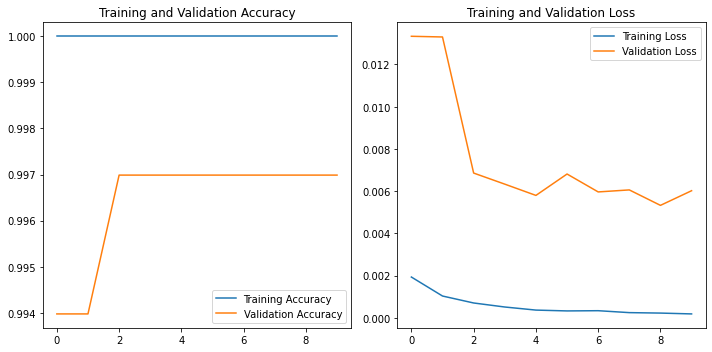

In [166]:
acc = history_cnn_model_1.history['accuracy']
val_acc = history_cnn_model_1.history['val_accuracy']

loss = history_cnn_model_1.history['loss']
val_loss = history_cnn_model_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import h5py


from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model

# CNN Model 2: Experimenting with Convolutional Pooling Pairs

In [28]:
cnn_model_2 = Sequential()

# Adding first pair {8C5-P2}
cnn_model_2.add(Conv2D(8, kernel_size=5, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
cnn_model_2.add(MaxPool2D())

# Adding second pair {16C5-P2}
cnn_model_2.add(Conv2D(16, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding third pair {32C5-P2}
cnn_model_2.add(Conv2D(32, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fourth pair {64C5-P2}
cnn_model_2.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
cnn_model_2.add(MaxPool2D())

# Adding fully connected layers
cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dense(5, activation='softmax'))

In [29]:
cnn_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

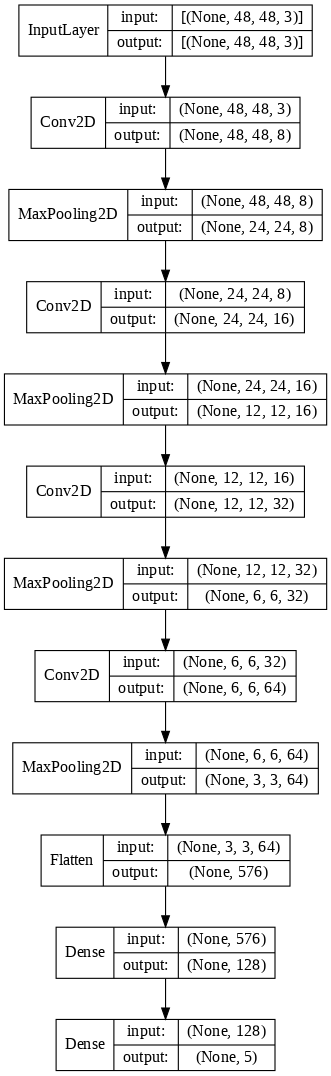

In [169]:
plot_model(cnn_model_2,
           to_file='model2.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [74]:
epochs = 10

# Defining schedule to update learning rate
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs), verbose=1)


In [75]:
epochs=10
history_cnn_model_2 = cnn_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
42/42 [==============================] - 10s 217ms/step - loss: 8.3180e-05 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.9940
Epoch 2/10
42/42 [==============================] - 7s 169ms/step - loss: 7.5934e-05 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.9940
Epoch 3/10
42/42 [==============================] - 7s 166ms/step - loss: 6.7591e-05 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 0.9940
Epoch 4/10
42/42 [==============================] - 8s 171ms/step - loss: 6.5873e-05 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 0.9940
Epoch 5/10
42/42 [==============================] - 8s 170ms/step - loss: 5.6009e-05 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 6/10
42/42 [==============================] - 8s 169ms/step - loss: 5.0408e-05 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 7/10
42/42 [==============================] - 8s 175ms/step - loss: 4.7565e-05 - accuracy: 1.0000 - val_loss: 0.0366 

range(0, 10)


Text(0.5, 1.0, 'Training and Validation Loss')

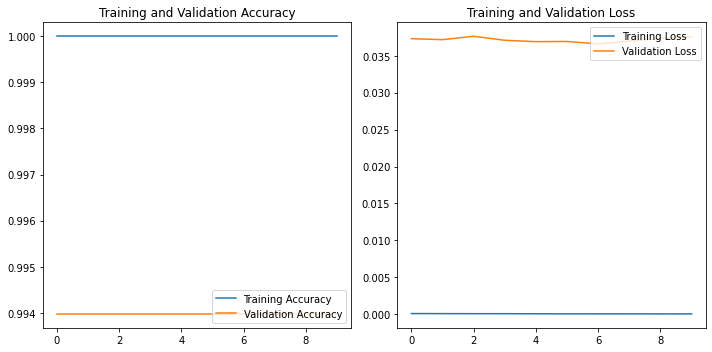

In [156]:
acc = history_cnn_model_2.history['accuracy']
val_acc = history_cnn_model_2.history['val_accuracy']

loss = history_cnn_model_2.history['loss']
val_loss = history_cnn_model_2.history['val_loss']

epochs_range = range(len(acc))
print(epochs_range)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

epochs_range = range(epochs)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.title('Training and Validation Loss')

# CNN Model 3: Experimenting with percentage dropout

In [33]:
cnn_model_3 = Sequential()

    # Adding first convolutional-pooling pair
cnn_model_3.add(Conv2D(64, kernel_size=5, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
cnn_model_3.add(MaxPool2D())
cnn_model_3.add(Dropout(0.3))

    # Adding second convolutional-pooling pair
cnn_model_3.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
cnn_model_3.add(MaxPool2D())
cnn_model_3.add(Dropout(0.3))

    # Adding third convolutional-pooling pair
cnn_model_3.add(Conv2D(256, kernel_size=5, padding='same', activation='relu'))
cnn_model_3.add(MaxPool2D())
cnn_model_3.add(Dropout(0.3))

    # Adding fourth convolutional-pooling pair
cnn_model_3.add(Conv2D(512, kernel_size=5, padding='same', activation='relu'))
cnn_model_3.add(MaxPool2D())
cnn_model_3.add(Dropout(0.3))

    # Adding fully connected layers
cnn_model_3.add(Flatten())
cnn_model_3.add(Dense(2048, activation='relu'))
cnn_model_3.add(Dropout(0.3))
cnn_model_3.add(Dense(5, activation='softmax'))

In [34]:
cnn_model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

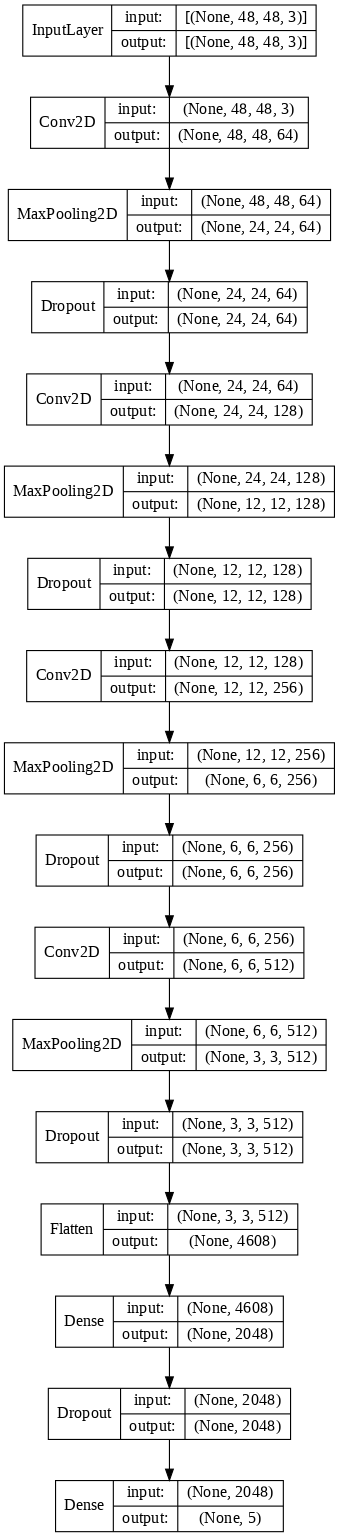

In [170]:
plot_model(cnn_model_3,
           to_file='model3.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [35]:
epochs = 10

# Defining schedule to update learning rate
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs), verbose=1)

In [36]:
epochs=10
history_cnn_model_3 = cnn_model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
42/42 [==============================] - 94s 2s/step - loss: 46.1909 - accuracy: 0.5500 - val_loss: 0.6681 - val_accuracy: 0.7048
Epoch 2/10
42/42 [==============================] - 90s 2s/step - loss: 0.3965 - accuracy: 0.8638 - val_loss: 0.3528 - val_accuracy: 0.8584
Epoch 3/10
42/42 [==============================] - 86s 2s/step - loss: 0.2473 - accuracy: 0.9210 - val_loss: 0.2274 - val_accuracy: 0.9187
Epoch 4/10
42/42 [==============================] - 89s 2s/step - loss: 0.1984 - accuracy: 0.9398 - val_loss: 0.2069 - val_accuracy: 0.9337
Epoch 5/10
42/42 [==============================] - 89s 2s/step - loss: 0.1148 - accuracy: 0.9646 - val_loss: 0.2934 - val_accuracy: 0.8735
Epoch 6/10
42/42 [==============================] - 89s 2s/step - loss: 0.1209 - accuracy: 0.9601 - val_loss: 0.1288 - val_accuracy: 0.9699
Epoch 7/10
42/42 [==============================] - 91s 2s/step - loss: 0.0812 - accuracy: 0.9767 - val_loss: 0.2352 - val_accuracy: 0.9036
Epoch 8/10
42/42 [=

Text(0.5, 1.0, 'Training and Validation Loss')

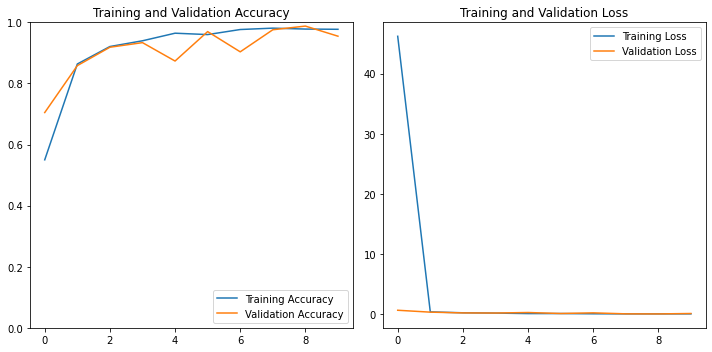

In [159]:
acc = history_cnn_model_3.history['accuracy']
val_acc = history_cnn_model_3.history['val_accuracy']

loss = history_cnn_model_3.history['loss']
val_loss = history_cnn_model_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1, 0.01)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# CNN Model 4: Experimenting with number of neurons in fully connected layer

In [39]:
cnn_model_4 = Sequential()

    # Adding first convolutional-pooling pair
cnn_model_4.add(Conv2D(128, kernel_size=5, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
cnn_model_4.add(MaxPool2D())

    # Adding second convolutional-pooling pair
cnn_model_4.add(Conv2D(256, kernel_size=5, padding='same', activation='relu'))
cnn_model_4.add(MaxPool2D())

    # Adding third convolutional-pooling pair
cnn_model_4.add(Conv2D(512, kernel_size=5, padding='same', activation='relu'))
cnn_model_4.add(MaxPool2D())

    # Adding fourth convolutional-pooling pair
cnn_model_4.add(Conv2D(1024, kernel_size=3, padding='same', activation='relu'))
cnn_model_4.add(MaxPool2D())

    # Adding fully connected layers
cnn_model_4.add(Flatten())
cnn_model_4.add(Dense(128 * (2 ** 5), activation='relu'))
cnn_model_4.add(Dense(43, activation='softmax'))

In [41]:
cnn_model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

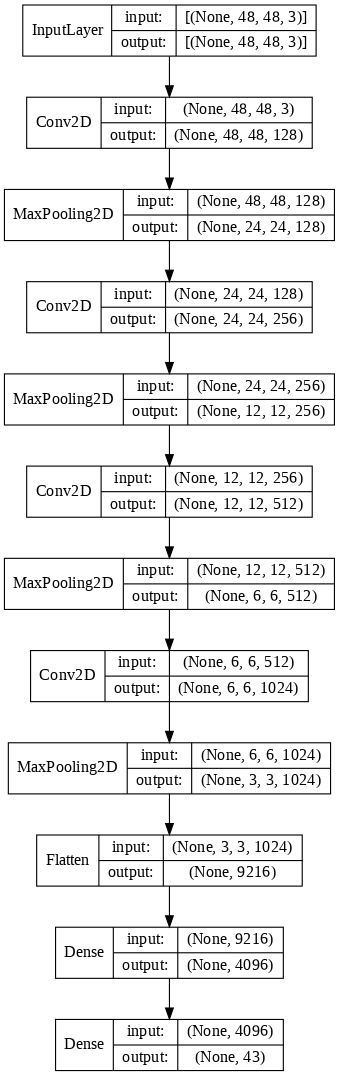

In [171]:
plot_model(cnn_model_4,
           to_file='model4.png',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB',
           dpi=80)

In [42]:
epochs=10
history_cnn_model_4 = cnn_model_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


42/42 [==============================] - 276s 7s/step - loss: 100.7508 - accuracy: 0.5463 - val_loss: 0.4730 - val_accuracy: 0.8042
Epoch 2/10
42/42 [==============================] - 275s 7s/step - loss: 0.2533 - accuracy: 0.9074 - val_loss: 0.1053 - val_accuracy: 0.9699
Epoch 3/10
42/42 [==============================] - 276s 7s/step - loss: 0.1111 - accuracy: 0.9631 - val_loss: 0.0397 - val_accuracy: 0.9849
Epoch 4/10
42/42 [==============================] - 269s 6s/step - loss: 0.1103 - accuracy: 0.9639 - val_loss: 0.2576 - val_accuracy: 0.8916
Epoch 5/10
42/42 [==============================] - 275s 7s/step - loss: 0.1168 - accuracy: 0.9601 - val_loss: 0.0372 - val_accuracy: 0.9849
Epoch 6/10
42/42 [==============================] - 278s 7s/step - loss: 0.0416 - accuracy: 0.9850 - val_loss: 0.0283 - val_accuracy: 0.9819
Epoch 7/10
42/42 [==============================] - 275s 7s/step - loss: 0.0391 - accuracy: 0.9850 - val_loss: 0.2769 - val_accuracy: 0.9096
Epoch 8/10
42/42 [====

Text(0.5, 1.0, 'Training and Validation Loss')

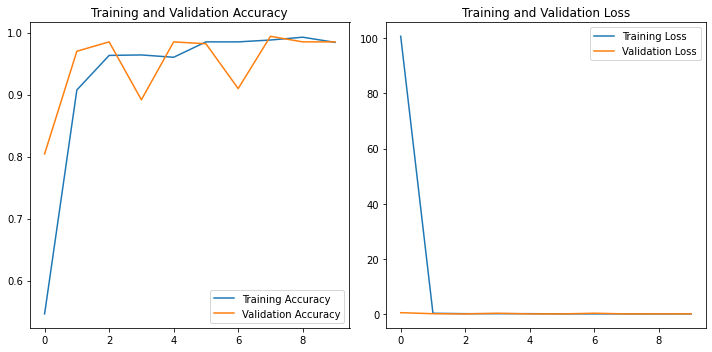

In [150]:
acc = history_cnn_model_4.history['accuracy']
val_acc = history_cnn_model_4.history['val_accuracy']

loss = history_cnn_model_4.history['loss']
val_loss = history_cnn_model_4.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Comapring all 4 models:

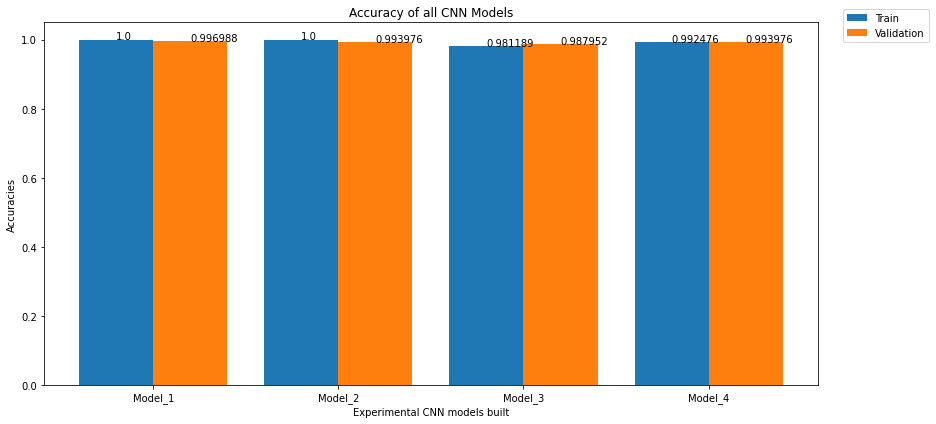

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

def addlabels(x,y,z):
    for i in range(len(x)):
        plt.text(i + z,y[i],y[i])

validation_m1 = round(max(history_cnn_model_1.history['val_accuracy']), 6)
validation_m2 = round(max(history_cnn_model_2.history['val_accuracy']), 6)
validation_m3 = round(max(history_cnn_model_3.history['val_accuracy']), 6)
validation_m4 = round(max(history_cnn_model_4.history['val_accuracy']), 6)

train_m1 = round(max(history_cnn_model_1.history['accuracy']), 6)
train_m2 = round(max(history_cnn_model_2.history['accuracy']), 6)
train_m3 = round(max(history_cnn_model_3.history['accuracy']), 6)
train_m4 = round(max(history_cnn_model_4.history['accuracy']), 6)

val_data = {'Model_1':validation_m1, 'Model_2':validation_m2,'Model_3':validation_m3,'Model_4':validation_m4}
train_data = {'Model_1':train_m1, 'Model_2':train_m2,'Model_3':train_m3,'Model_4':train_m4}

models = list(accuracy_data.keys())
val_accuracies = list(val_data.values())
train_accuracies = list(train_data.values())
X_axis = np.arange(len(models))
fig = plt.figure(figsize = (13, 6))
 
# creating the bar plot
plt.bar(X_axis - 0.2, train_accuracies, width = 0.4, label="Train")
plt.bar(X_axis + 0.2, val_accuracies, width = 0.4, label="Validation")
addlabels(models, train_accuracies, -0.2)
addlabels(models, val_accuracies, +0.2)
plt.xticks(X_axis, models)
plt.xlabel("Experimental CNN models built")
plt.ylabel("Accuracies")
plt.title("Accuracy of all CNN Models")
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()


# Time taken for each CNN model:

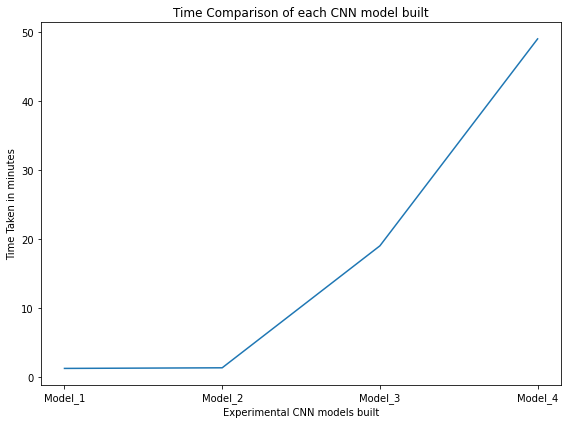

In [113]:
time_data = {'Model_1': 1.23, 'Model_2':1.32,'Model_3':19,'Model_4':49}
models = list(time_data.keys())
timings = list(time_data.values())
X_axis = np.arange(len(models))
fig = plt.figure(figsize = (8, 6))
 
# creating the bar plot
plt.plot(models, timings)

plt.xticks(X_axis, models)
plt.xlabel("Experimental CNN models built")
plt.ylabel("Time Taken in minutes")
plt.title("Time Comparison of each CNN model built")
plt.show()